### IMPORTS

In [11]:
from Inference import BBVI 
import numpy as np

In [12]:
import torch
import matplotlib.pyplot as plt
import _pickle as pickle

### EXAMPLE

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [14]:
# load data
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [19]:
filename = 'C:\\Users\\cortax\\Documents\\BayesianNN\\Experiments\\foong\\tanh\\MAP\\models\\' + '3Layers_10Neurons_(1)'
filehandler = open(filename, 'rb')
netparam = pickle.load(filehandler)

In [20]:
Net = BBVI.VariationalNetwork(input_size=netparam['input_size'],
                              output_size=netparam['output_size'],
                              layer_width=netparam['layer_width'],
                              nb_layers=netparam['nb_layers'])
Net.set_network(netparam)
Net.set_device(device)
Net.requires_grad_rhos(False)

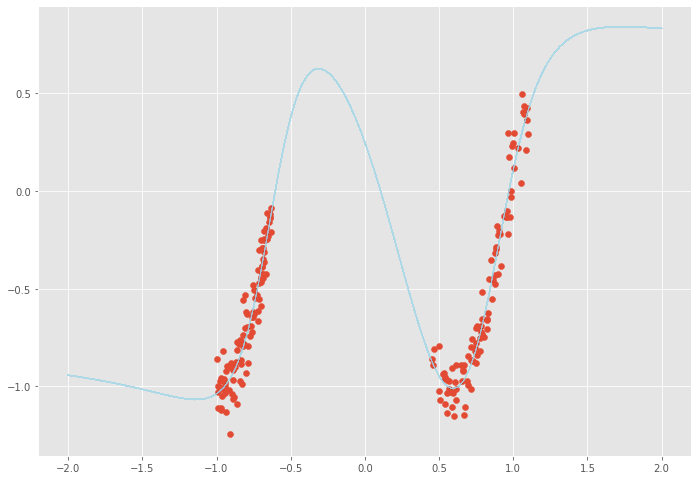

In [21]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue') 

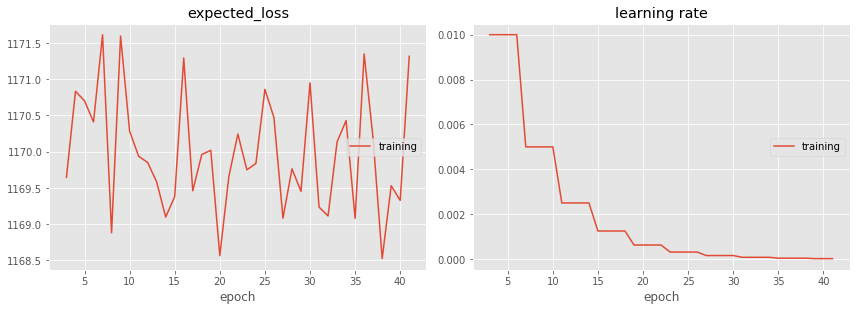

expected_loss:
training   (min: 1168.051, max: 1183.720, cur: 1171.316)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


KeyboardInterrupt: 

In [22]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.01}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 3, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=1000, n_iter=100, n_ELBO_samples=1, plot=True)

In [23]:
mcmc = BBVI.MCMCsimulator(Net)

In [24]:
samples, acceptance, proba = mcmc.MetropolisHastings(x_data, y_data, 10000, 0.002)

<IPython.core.display.Javascript object>


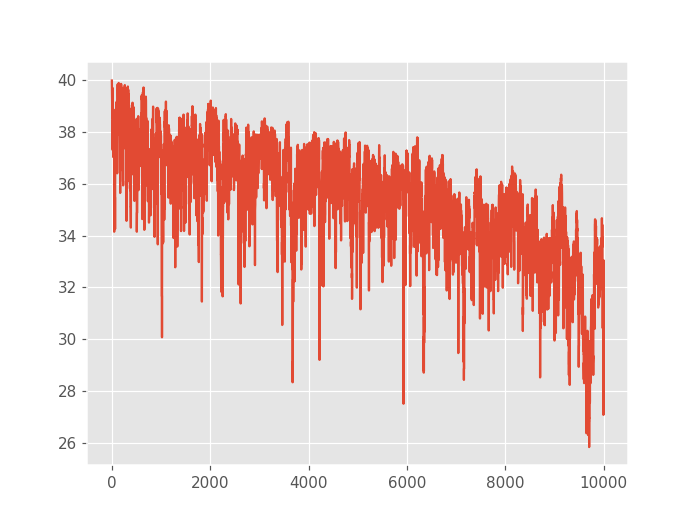

In [25]:
%matplotlib notebook
plt.plot(torch.stack(proba).detach().cpu().numpy())

In [26]:
np.mean(acceptance)

0.6397